## Moduł 15 - zadania 

Wybierz zbiór danych z tych, które wykorzystywane były w module o regresji lub klasyfikacji. Dla któregoś z tych zbiorów stwórz Pipeline, w którym zawrzesz proces przygotowania danych i naucz nowy model, porównując go z tymi stworzonymi w tamtych modułach.

Dla stworzonego wcześniej Pipeline’a wybierz najlepsze hiperparametry na podstawie podzbiorów walidacyjnych i siatki hiperparametrów (skorzystaj z GridSearch).

In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score



In [7]:
diabetes = pd.read_csv('diabetes.csv')

In [8]:
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]
print('X:')
display(X)
print('\ny:')
display(y)

X:


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age
0,0,171,80,34,23,43.509726,1.213191,21
1,8,92,93,47,36,21.240576,0.158365,23
2,7,115,47,52,35,41.511523,0.079019,23
3,9,103,78,25,304,29.582192,1.282870,43
4,1,85,59,27,35,42.604536,0.549542,22
...,...,...,...,...,...,...,...,...
14995,10,65,60,46,177,33.512468,0.148327,41
14996,2,73,66,27,168,30.132636,0.862252,38
14997,0,93,89,43,57,18.690683,0.427049,24
14998,0,132,98,18,161,19.791645,0.302257,23



y:


0        0
1        0
2        0
3        1
4        0
        ..
14995    1
14996    1
14997    0
14998    0
14999    1
Name: Diabetic, Length: 15000, dtype: int64

EAD została przeprowadzona w module 14. 

Teraz podzielimy zbiór na część treningową i testową. Przyjmiemy parametr stratify = y w celu odwzorowania struktury estymatora do struktury populacji. Przypomnijmy, że około 1/3 badanych kobiet zachorowała na cukrzycę. 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[['Pregnancies', 'Age']], y, test_size=0.30, random_state=0, stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], X_test.shape[0]))

Treningowe obserwacje: 10500
Testowe obserwacje: 4500


# SVM - wersja liniowa

## Transformacja i klasyfikacja danych  

Rozpoczniemy od standaryzacji danych i zastosowania klasyfikacji

In [5]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("scaler",StandardScaler()), # transformacja 
    ("SVM", SVC()), # klasyfikacja
   ])


W przypadku jądra maszyn nośnych wyróżniamy dwa hiperparametry: C i $\gamma$. Algorytm SVC tworzy granice decyzyjności na podstwie której przyporządkowuje obserwacje do dwóch lub więcej klas.

Parametr $C$ dodaje karę za każdy źle sklasyfikowany punkt. 

    + Jeśli wartość $C$ jest mała, to kara za źle sklasyfikowane punkty jest niska, a co za tym idzie granica decyzyjności ma duży margines. Kosztem jest większa ilość obserwacji źle sklasyfikowanych.  
    + Jeśli wartość $C$ jest duża, to kara za źle sklasyfikowane punkty jest wysoka. Algorytm SVM próbuje minimalizować liczbę źle sklasyfikowanych przykładów, co przekłada się na granicę decyzyjności z mniejszym marginesem. 
    
Kara za źle sklasyfikowane dane nie jest taka sama dla wszytskich obserwacji: jest wprost proporcjonalna do odległości obserwacji od granicy decyzyjności. 

Drugim hiperparametrem modelu SVM jest $\gamma$. Jest on użyty w tzw. (Gaussowskiej) radialnej funkcji bazowej (radial basis function (RBF)). Przypomnijmy postać RBF:

$$ \phi(\mathbf{x},\ell)= \exp (-\gamma \| \mathbf{x}-\ell \|^2 )$$

Jeżeli wartość $\gamma$ jest wysoka, to punkty muszą znajdować się bardzo blisko siebie, żeby być zaliczone do tej samej klasy. Powoduje to skłonność modelu do przetrenowania. 

Dostroimy model wykorzystując metodę przeszukiwania siatki. Rozpoczniemy od zdefiniowania słownika z wartościami parametrów:



In [6]:
# parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
parameteres = {'SVM__C':[0.001,0.1,10,100], 'SVM__gamma':[0.1,0.01]}

# Dostrajanie modelu

Przejdziemy teraz do dostrajania modelu metodą przeszukiwania siatki. 

In [7]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.001, 0.1, 10, 100],
                         'SVM__gamma': [0.1, 0.01]})

Wypisanie wartości najlepszych parametrów wskazanych przez metodę przeszukiwania siatki

In [8]:
print(grid.best_params_)

{'SVM__C': 100, 'SVM__gamma': 0.1}


Zadanie polega na klasyfikacji pacjenta jako chorego na cukrzycę bądź nie. Zatem wartość odpowiedzi modelu powinna wynosić zero lub jeden:

In [9]:
y_pred = grid.predict(X_test)
y_pred = np.round(y_pred, decimals=0)

# Macierz pomyłek

Macierz wskazuje na ile model trafnie typuje odpowiedzi. Wyświetlimy macierz pomyłek.

[[2703  297]
 [ 329 1171]]


C:\Users\zfech\AppData\Local\Temp\ipykernel_3100\1668408196.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
C:\Users\zfech\AppData\Local\Temp\ipykernel_3100\1668408196.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''])


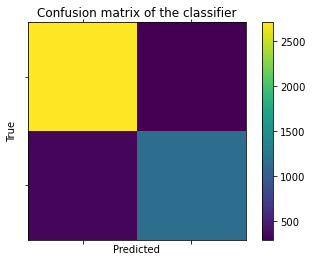

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''])
ax.set_yticklabels([''])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [12]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3000
           1       0.80      0.78      0.79      1500

    accuracy                           0.86      4500
   macro avg       0.84      0.84      0.84      4500
weighted avg       0.86      0.86      0.86      4500



Wnioski:

    1. Model wykazuje wysoką dokładność (86%)
    2. W zbiorze treningowycm około 1/3 obserwacji ma cechę (chory na cukrzycę). Zbiór nie jest zbalansowany, więc bierzemy pod uwagę średnie ważone. W tym przypadku wszystke miary dokładności są równe i wynoszą 86%.
    3. Miary nie uwzględniające wag sa na poziomie 84%.


# PCA

Zastosujemy najpierw metodę PCA dla dwóch składowych głównych

In [11]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(X)



StandardScaler()

In [12]:
scaled_data = scaler.transform(X)

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=2)

In [20]:
pca.fit(scaled_data)

PCA(n_components=2)

In [21]:
x_pca = pca.transform(scaled_data)

In [23]:
pca.explained_variance_ratio_

array([0.1696251 , 0.12629706])

Zastosujemy metodę PCA, która wyjasnia ponad 90 procent zmienności wariancji

In [27]:
pca90 = PCA(n_components=0.90)

In [28]:
pca90.fit(scaled_data)

PCA(n_components=0.9)

In [35]:
x_pca_90 = pca90.transform(scaled_data)

In [36]:
pca90.explained_variance_ratio_

array([0.1696251 , 0.12629706, 0.12397574, 0.12203939, 0.12040256,
       0.11756081, 0.11295178, 0.10714756])

In [37]:
sum(pca90.explained_variance_ratio_)

1.0

Każda składowa wyjaśnia ponad 10% zmienności, więc żeby uzyskać ponad 90% nie jesteśmy w stanie zredukować wymiaru. Próbujemy dla 80% wyjasnionej wariancji

In [38]:
pca80 = PCA(n_components=0.80)

In [39]:
pca80.fit(scaled_data)

PCA(n_components=0.8)

In [40]:
x_pca_80 = pca80.transform(scaled_data)

In [41]:
pca80.explained_variance_ratio_

array([0.1696251 , 0.12629706, 0.12397574, 0.12203939, 0.12040256,
       0.11756081, 0.11295178])

# Wykorzystane źródła

1. www.sigmaquality.pl/uncategorized/algorytm-support-vector-machine-svm-zaliczany-jest-do-estymatorow-machine-learning-uczenia-z-nadzorem-w-oparciu-o-procesy-klasyfikacji-i-analizy-regresji-klasyfikator-svm-wykorzystuje-algorytm-optyma/

2. https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167